## Анализ отзывов

В рамках данного кейса предлагается с помощью ИИ и машинного обучения поизучать отзывы людей на железнодорожные вокзалы Москвы. В рамках кейса предоставляются отзывы пользователей с Яндекс-карт, но возможно дополнительно использовать доступные в Интернет данные. 

Что ожидается в качестве результата:
* Инфографика, наглядно демонстрирующая полученные командой результаты
* Доклад, представляющий эти результаты
* Код в Jupyter Notebook с анализом данных

В данном ноутбуке показывается, как получить доступ к датасету, и первые шаги по его обработке с помощью доступных открытых моделей с HuggingFace, и с помощью YandexGPT. Можно использовать данный ноутбук как оправную точку для выполнения задания, расширив его дополнительными идеями, например:
* Кластеризация отзывов
* Обучение своих моделей для классификации тематики отзывов
* Использование предобученных NER-моделей
* Подробный анализ отзывов с помощью LLM

> В начале работы мы будем использовать модель с HuggingFace, поэтому работа будет быстрее, если вы будете запускать код на узле с поддержкой GPU

### Получение датасета

In [1]:
!wget http://www.soshnikov.com/temp/data/rail_reviews.zip

--2024-05-22 07:52:38--  http://www.soshnikov.com/temp/data/rail_reviews.zip
Resolving www.soshnikov.com (www.soshnikov.com)... 79.137.227.122
Connecting to www.soshnikov.com (www.soshnikov.com)|79.137.227.122|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 390394 (381K) [application/zip]
Saving to: ‘rail_reviews.zip’

     0K .......... .......... .......... .......... .......... 13% 2.72M 0s
    50K .......... .......... .......... .......... .......... 26% 7.62M 0s
   100K .......... .......... .......... .......... .......... 39% 5.74M 0s
   150K .......... .......... .......... .......... .......... 52% 7.00M 0s
   200K .......... .......... .......... .......... .......... 65% 6.65M 0s
   250K .......... .......... .......... .......... .......... 78% 6.64M 0s
   300K .......... .......... .......... .......... .......... 91% 6.01M 0s
   350K .......... .......... .......... .                    100% 7.12M=0.07s

2024-05-22 07:52:38 (5.56 MB/s) - ‘rail_re

In [2]:
!unzip *.zip

Archive:  rail_reviews.zip
  inflating: reviews_Belorussky_railway_station.json  
  inflating: reviews_Kazan_Station.json  
  inflating: reviews_Kursky_station.json  
  inflating: reviews_Kyiv_railway_station.json  
  inflating: reviews_Paveletsky_railway_station.json  
  inflating: reviews_Rizhsky_railway_station.json  
  inflating: reviews_Savyolovsky_station.json  
  inflating: reviews_Vostochny_station.json  


### Преобразуем данные в DataFrame

Как видите, каждый вокзал представлен своим набором отзывов следующего вида:

In [2]:
import json
j = json.load(open('reviews_Belorussky_railway_station.json'))
j[0]

{'id': 1251,
 'dislike': 1,
 'like': 10,
 'review_text': 'Очень красивое место, вежливый персонал.\nЕздила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.',
 'author': 'Александра Подгайская',
 'review_rating': 5,
 'datetime': '2024-01-12T16:53:33.611Z'}

Для удобства, сведём все отзывы в одну табличку. Для этого нам нужно будет добавить в каждое JSON-описание отзыва название вокзала.

In [6]:
import pandas as pd
import os
from glob import glob

res = []
for fn in glob('*.json'):
    j = json.load(open(fn))
    for x in j:
        x['station'] = fn.split('_')[1]
    res.extend(j)
    
df = pd.DataFrame(res)
df

,id,dislike,like,review_text,author,review_rating,datetime,station
0,1251,1,10,"Очень красивое место, вежливый персонал.\nЕзди...",Александра Подгайская,5,2024-01-12T16:53:33.611Z,Belorussky
1,1252,0,5,"Расположен очень удобное, строятся новые пути ...",Пользователь Э.,5,2023-11-10T21:33:56.176Z,Belorussky
2,1253,2,7,Очень уютный и удобный вокзал. Мне он очень нр...,Н И,5,2023-08-25T14:27:29.327Z,Belorussky
3,1254,1,5,"Красивое здание , очень удобно расположено в т...",Liliya Zugrova,5,2023-11-27T11:50:16.388Z,Belorussky
4,1255,2,7,С появление новых веток и маршрутов все стало ...,Татьяна Цымлова,5,2023-11-25T06:43:16.558Z,Belorussky
...,...,...,...,...,...,...,...,...
2264,2266,0,1,"Отличный вокзал. Новый, современный, прям из в...",Анна Елагина,5,2024-02-02T04:55:15.074Z,Vostochny
2265,2267,1,0,Бывал недавно там )) очень вкусная кухня \nКла...,Дмитрий,5,2023-11-12T14:21:47.541Z,Vostochny
2266,2268,0,0,Отличный и красивый вокзал. Чистые туалеты и б...,Валентина Архимановна,5,2024-01-31T10:53:36.364Z,Vostochny
2267,2269,3,10,"Это не вокзал , а скорее узловая станция или п...",Владислав Баранов,2,2023-12-06T12:03:14.107Z,Vostochny


Посмотрим на количество отзывов по вокзалам:

<Axes: xlabel='station'>

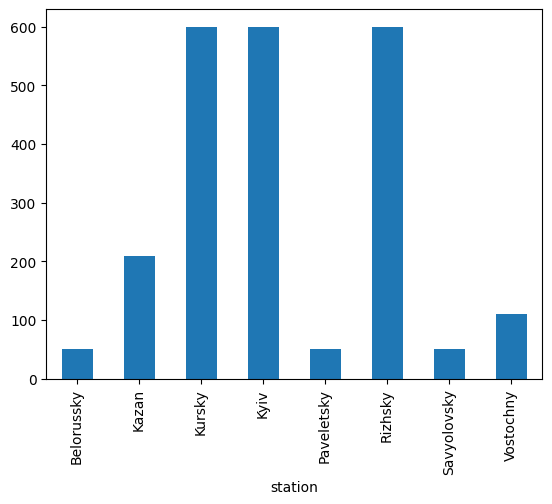

In [4]:
df.groupby('station')['review_text'].count().plot.bar()

### Обогащение данных с помощью модели с HuggingFace

Для обогащения данных можно использовать различные нейросетевые модели. Для начала, попробуем определить тональность текста.

Попробуем использовать модель [blanchefort/rubert-base-cased-sentiment-rurewiews](https://huggingface.co/blanchefort/rubert-base-cased-sentiment-rurewiews) с HuggingFace, натренированную на отзывах, с длиной 512 токенов. По умолчанию код из карточки модели выдает следующие классы:
* 0: NEUTRAL
* 1: POSITIVE
* 2: NEGATIVE

> Код не учитывает возможность работы на GPU, поэтому придётся внести в код несколько исправлений, чтобы можно было быстрее выполнять код на GPU.

In [7]:
import torch
from transformers import AutoModelForSequenceClassification
from transformers import BertTokenizerFast

device = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = BertTokenizerFast.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews')
model = AutoModelForSequenceClassification.from_pretrained('blanchefort/rubert-base-cased-sentiment-rurewiews', return_dict=True)
model.to(device)

@torch.no_grad()
def predict(text):
    inputs = tokenizer(text, max_length=512, padding=True, truncation=True, return_tensors='pt')
    inputs = inputs.to(device)
    outputs = model(**inputs)
    predicted = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted = torch.argmax(predicted, dim=1).cpu().numpy()
    return predicted


/home/jupyter/.local/lib/python3.10/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


Проверим, работает ли эта функция:

In [8]:
predict([
    'Ничего так вокзал, обычный...',
    'Обожаю этот вокзал, там такие симпатичные бомжи!',
    'Ненавижу это вокзал, поезда всегда опаздывают минимум на 20 минут'])

array([0, 1, 2])

Чтобы применить модель ко всему датасету, разобьем его на небольшие части, примерное по 200 отзывов, и предскажем тональность каждой из этих частей.

In [9]:
from tqdm.auto import tqdm
import numpy as np 

res = []
for d in tqdm(np.array_split(df,10)):
    z = list(d['review_text'])
    p = predict(z)
    res.extend(p)

100%|██████████| 10/10 [15:23<00:00, 92.35s/it] 


Для удобства вставим колонку `sentiment` в датасет, но при этом изменим кодирование: будем представлять негативный отзыв цифрой -1.

In [10]:
df['sentiment'] = pd.Series(res).apply(lambda x: -1 if x==2 else x)

Запишем получившийся датасет на диск:

In [11]:
df.to_csv('dataset_with_sentiment.csv',index=False)

Теперь можем посмотреть, какие вокзалы самые негативные или позитивные в Москве:

In [12]:
def count_pos(x):
    return x[x==1].count()
def count_neg(x):
    return x[x==-1].count()


df.groupby('station').agg({'sentiment' : ['mean', count_pos, count_neg ], 'review_text': 'count'})

sentiment                     review_text
                 mean count_pos count_neg       count
station                                              
Belorussky   0.680000        36         2          50
Kazan        0.647619       143         7         210
Kursky       0.395000       277        40         600
Kyiv         0.599332       385        26         599
Paveletsky   0.540000        27         0          50
Rizhsky      0.560000       374        38         600
Savyolovsky  0.480000        29         5          50
Vostochny    0.618182        71         3         110

В этом месте вы можете остановить виртуальную машину с GPU и перейти на более дешевый вариант **c1.4**

### Используем YandexGPT для извлечения смысла из отзывов

Попробуем использовать больщую языковую модель для извлечения структурированной информации из текстов отзывов. Для этого нам будет удобно использовать библиотеку [yandex_chain](https://github.com/yandex-datasphere/yandex-chain).

In [2]:
%pip install yandex_chain

Defaulting to user installation because normal site-packages is not writeable
  Using cached yandex_chain-0.0.7-py3-none-any.whl

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip


Для работы с YandexGPT, нам потребуются значения `api_key` и `folder_id`. Их надо взять из секретов датасферы.

In [46]:
folder_id = "..."
api_key = "..."

Создадим объект YandexGPT и проверим, как он работает:

In [47]:
from yandex_chain import YandexLLM, YandexGPTModel
LLM = YandexLLM(model=YandexGPTModel.Pro, folder_id=folder_id, api_key=api_key)

LLM.invoke("Расскажи анекдот про JSON и XML")

'**Встретились JSON и XML.**  \n\nJSON говорит: «Я крутой формат обмена данными, быстрый и компактный!»\nXML отвечает: «Зато я более гибкий, богатый функционально и поддерживаемый различными приложениями».  \nПосмотрели они друг на друга и пожали плечами – не поймёшь, кто из них прав. Пришёл программист, использовал и JSON, и XML для своих задач – и остался доволен!'

Для обработки, чтобы ускорить процесс демонстрации, выберем по 10 записей из каждого вокзала:

In [24]:
import pandas as pd

df = pd.read_csv('dataset_with_sentiment.csv')
df_sample = df.groupby('station').apply(lambda x: x.sample(10)).reset_index(drop=True)
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,sentiment
0,1262,2,16,"Обожаю вокзал, из всех вокзалов , обладает так...",Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,1
1,1283,0,6,"Большой просторный, красивый вокзал. Зал ожида...",Мария Рыжкова,5,2024-01-20T08:19:35.208Z,Belorussky,1
2,1279,0,0,"Один из красивых вокзалов, г. Москвы, \nХороше...",Лекс,5,2023-11-04T12:49:54.572Z,Belorussky,1
3,1300,7,21,"Удобно расположен, есть камеры хранения, возмо...",Люси,5,2023-04-05T23:12:23.159Z,Belorussky,0
4,1291,2,7,"Красивое, атмосферное место, а ещё и функциона...",Светлана Смирнова,5,2024-02-13T12:34:33.803Z,Belorussky,1
...,...,...,...,...,...,...,...,...,...
75,2198,0,0,"Небольшой вокзал на востоке столицы, с удобной...",Андрей Кочкин,4,2024-01-06T09:36:59.239Z,Vostochny,0
76,2175,0,0,"Вокзал свежий,но очень маленький.Иногда большо...",Анна Тихонова,4,2024-01-20T12:28:08.435Z,Vostochny,0
77,2270,0,3,Очень приятный новый вокзал! Разобраться сложн...,Наталья Байбакова,5,2023-12-24T13:10:29.484Z,Vostochny,1
78,2180,1,0,"Посещал данный вокзал, из преимуществ, есть по...",Tomm,5,2023-10-29T11:07:27.166Z,Vostochny,1


Попробуем выделить смысл из текста отзыва. Для примера выберем три аспекта отзывов: транспортная доступность вокзала, его чистота и точность хождения поездов. По каждому из этих аспектов попробуем выделить оценку, также в целом положительные и отрицательные моменты, и список тегов, о чем этот отзыв.

In [58]:
prompt = """
Прочитай следующий отзыв о вокзале в тройных обратных кавычках: ````{}```.
Из этого отзыва тебе необходимо выделить следующую информацию:
* sentiment - этот отзыв позитивный (positive), негативный (negative) или нейтральный (neutral)
* transport - транспортная доступность вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* cleanliness - чистота вокзала, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* schedule - точность хождения поездов, по шкале 1..5, если об это говорится в отзыве. Если нет - 0
* positive - краткий список позитивных моментов из отзыва
* negative - краткий список негативных моментов из отзыва
* tags - краткий список тегов, о чем этот отзыв, например: cleanliness, transport, trains
Результат необходимо вернуть в формате JSON такого вида:
{{
  "sentiment" : "...",
  "transport" : ...,
  "cleanliness" : ...,
  "schedule" : ...,
  "positive" : ["...", ...],
  "negative" : ["...", ...],
  "tags" : ["..."]
}}
Обязательно пиши все строки внутри JSON в двойных кавычках. Не забывай ставить запятые после 
всех полей в JSON, кроме последнего.
"""

txt = df['review_text'].iloc[0]
print(txt)
res = LLM.invoke(prompt.format(txt))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


'{\n  "sentiment": "positive",\n  "transport": 0,\n  "cleanliness": 5,\n  "schedule": 0, \n  "positive": ["Очень красивое место", "вежливый персонал", "комфортно", "чистое бельё", "тепло", "можно с животными", "дают горячий чай прям в постель"],\n  "negative": [],\n  "tags": ["Вокзал", "Поезд"]\n}'

Поскольку возврат результата в формате JSON не гарантируется, попробуем использовать JsonOutputParser из библиотки LangChain для выделения результата в формате JSON. Но в дальнейшем если будут возникать ошибки парсинга - мы будет просто игнорировать такие строки.

In [54]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.exceptions import OutputParserException
jop = JsonOutputParser()

txt = df['review_text'].iloc[0]
print(txt)
res = jop.parse(LLM.invoke(prompt.format(txt)).replace('\'','"'))
res

Очень красивое место, вежливый персонал.
Ездила на поезде из Москвы в Беларусь, комфортно, белье чистое, тепло, можно с животными. Дают горячий чай прям в постель, можно даже не переутруждаться, там о вВс и вашем комфорте позаботиться квалифицированные сотрудники.


{'sentiment': 'positive',
 'transport': 0,
 'cleanliness': 1,
 'schedule': 0,
 'positive': ['Очень красивое место',
  'вежливый персонал',
  'комфортно',
  'тепло',
  'можно с животными'],
 'negative': [],
 'tags': ['вокзал']}

Сохраним колонку `sentiment`, распознанную моделью HuggingFace.

In [27]:
pmap = { -1 : 'negative', 0 : 'neutral', 1 : 'positive' }
df_sample['hf_sentiment'] = df_sample['sentiment'].apply(lambda x: pmap[x])
df_sample.drop(columns=['sentiment'],inplace=True)

Теперь пройдёмся по всем строкам таблицы и извлечём информацию с помощью LLM. Для начала добавим новые пустые поля в таблицу, для хранения извлечённых значений:

In [ ]:
for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
    df_sample[f]=np.nan

Теперь собственно займёмся извлечением. Если для какого-то отзыва YandexGPT вернёт некорректный JSON, то отзыв будет пропущен. Мы можем запустить этот код несколько раз, чтобы попробовать распознать все отзывы. Он будет пропускать те отзывы, для которые поле `positive` уже заполнено.

> Обратите внимание, что мы используем несколько приёмов для уменьшения проблем с JSON. Например, если возвращенный JSON содержит вводный текст вида *Вот документ, который вы просили: {...}*, то мы выделяем весь текст между символами `{` и `}`. Также заменяем одинарные кавычки на двойные.

In [69]:
from tqdm.auto import tqdm
from yandex_chain import YException
import numpy as np

def lin(x):
    if isinstance(x,list):
        return ','.join(x)
    else:
        return x
    
def cut(x):
    if x.startswith('{'):
        return x
    if '{' in x and '}' in x:
        mk1 = x.find('{')
        mk2 = x.find('}', mk1) + 1
        return x[ mk1 : mk2 ]
    return x

for i,r in tqdm(df_sample.iterrows()):
    txt = r['review_text']
    if not pd.isnull(r['positive']):
        continue # уже распознано
    try:
        res = jop.parse(cut(LLM.invoke(prompt.format(txt)).replace('\'','"')))
        for f in ["sentiment","transport","cleanliness", "schedule", "positive", "negative", "tags"]:
            df_sample.at[i,f] = lin(res[f])
    except YException as ye:
        print(f"YandexGPT Error: {e}")
        break
    except Exception as e:
        print(f'Error: {e}') 

80it [00:02, 38.45it/s]


Посмотрим на результат:

In [70]:
df_sample.to_csv('dataset_sample_with_GPT.csv')
df_sample

,id,dislike,like,review_text,author,review_rating,datetime,station,hf_sentiment,sentiment,transport,cleanliness,schedule,positive,negative,tags
0,1262,2,16,"Обожаю вокзал, из всех вокзалов , обладает так...",Алекс,5,2023-04-22T16:43:05.097Z,Belorussky,positive,positive,5.0,0.0,0.0,"уникальная история,интересная архитектура,совр...",,"вокзал,транспорт,история"
1,1283,0,6,"Большой просторный, красивый вокзал. Зал ожида...",Мария Рыжкова,5,2024-01-20T08:19:35.208Z,Belorussky,positive,positive,5.0,0.0,0.0,"Большой просторный, красивый вокзал.,Зал ожида...",,вокзал
2,1279,0,0,"Один из красивых вокзалов, г. Москвы, \nХороше...",Лекс,5,2023-11-04T12:49:54.572Z,Belorussky,positive,positive,2.0,0.0,0.0,"Один из красивых вокзалов,Хорошее расположение...",,
3,1300,7,21,"Удобно расположен, есть камеры хранения, возмо...",Люси,5,2023-04-05T23:12:23.159Z,Belorussky,neutral,positive,2.0,0.0,0.0,"удобное расположение,камеры хранения,возможнос...",высокие цены в ГУМе,"вокзал,Красная площадь,ГУМ"
4,1291,2,7,"Красивое, атмосферное место, а ещё и функциона...",Светлана Смирнова,5,2024-02-13T12:34:33.803Z,Belorussky,positive,positive,0.0,0.0,0.0,"красивое место,атмосферное место,функционально...",,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2198,0,0,"Небольшой вокзал на востоке столицы, с удобной...",Андрей Кочкин,4,2024-01-06T09:36:59.239Z,Vostochny,neutral,neutral,2.0,0.0,0.0,Удобная транспортная доступность и логистика,"Платформы узкие, от последнего вагона до экска...","вокзал,транспорт"
76,2175,0,0,"Вокзал свежий,но очень маленький.Иногда большо...",Анна Тихонова,4,2024-01-20T12:28:08.435Z,Vostochny,neutral,negative,0.0,0.0,0.0,вокзал свежий,"очень маленький вокзал,большое скопление людей...","вокал,транспорт"
77,2270,0,3,Очень приятный новый вокзал! Разобраться сложн...,Наталья Байбакова,5,2023-12-24T13:10:29.484Z,Vostochny,positive,positive,1.0,5.0,0.0,"приятный новый вокзал!,всё удобно,рядом торгов...",,"вокзал,метро"
78,2180,1,0,"Посещал данный вокзал, из преимуществ, есть по...",Tomm,5,2023-10-29T11:07:27.166Z,Vostochny,positive,positive,0.0,5.0,0.0,"есть под СВХ бесплатная парковка,внутри чисто,...",,чистота


## Делаем выводы и строим инфографику 

Посмотрим, насколько совпадают предсказания sentiment между YandexGPT и моделью с HuggingFace:

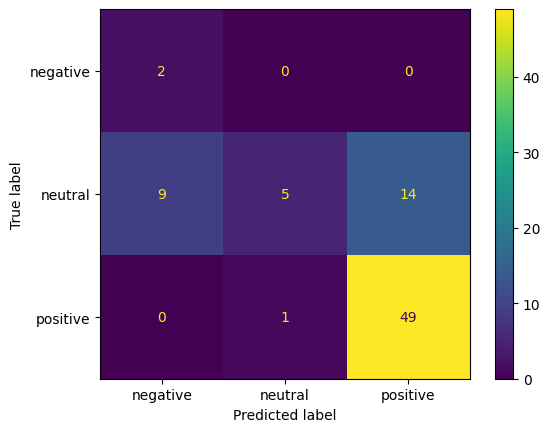

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(df_sample['hf_sentiment'],df_sample['sentiment'])

Посмотрим на средние значения показателей по всем вокзалам. Для этого сначала заменим нулевые значения на NaN, и затем осуществим аггрегацию:

In [74]:
for f in ["transport","cleanliness", "schedule"]:
    df_sample[f] = df_sample[f].apply(lambda x: np.nan if x==0 else x)

df_sample.groupby('station').agg( {'transport' : 'mean', 'cleanliness' : 'mean', 'schedule' : 'mean'})

,transport,cleanliness,schedule
station,,,
Belorussky,3.500000,3.500000,NaN
Kazan,2.000000,5.000000,1.0
Kursky,3.000000,3.000000,1.0
Kyiv,1.666667,3.666667,NaN
Paveletsky,3.800000,4.333333,NaN
Rizhsky,NaN,4.500000,5.0
Savyolovsky,2.666667,4.400000,NaN
Vostochny,2.571429,5.000000,NaN


Такую же информацию можно представить в виде графика:

<Axes: xlabel='station'>

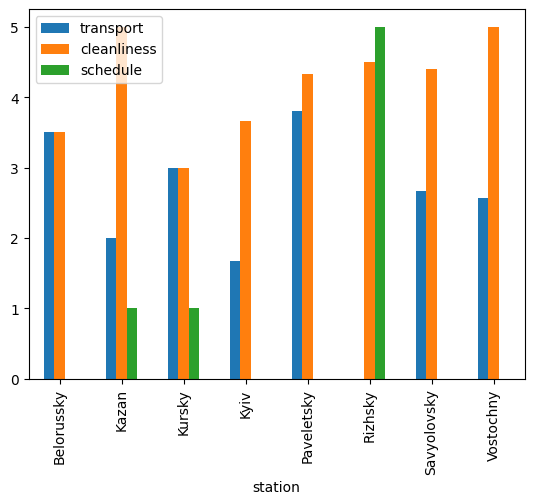

In [111]:
df_sample.groupby('station').agg(
    {'transport' : 'mean', 
     'cleanliness' : 'mean', 
     'schedule' : 'mean'}).plot.bar()

Теперь научимся извлекать интересующие нас отзывы по тегам. Для этого посмотрим на список всех тегов:

In [83]:
tags = list(df_sample['tags'].apply(lambda x: str(x).split(',')))
tags = set(sum(tags,[])) - { 'nan', '' }
tags

{'vip',
 'Анимация',
 'Вокзал',
 'ГУМ',
 'Железнодорожная станция',
 'Железнодорожный вокзал',
 'Киевский вокзал',
 'Красная площадь',
 'Отель',
 'Павелецк-Плаза',
 'Поезда',
 'РЖД',
 'Транзит',
 'безопасность',
 'билеты',
 'вокал',
 'вокзал',
 'вокзалы',
 'воспоминания из детства',
 'еда',
 'железнодорожный вокзал',
 'железнодорожный транспорт',
 'зона отдыха',
 'история',
 'камера хранения',
 'кафе',
 'кофейня',
 'культура',
 'метро',
 'музей',
 'музей техники',
 'общественное питание',
 'отдых',
 'отзыв',
 'парковка',
 'пассажиры',
 'пересадки',
 'персонал',
 'платформа',
 'платформы',
 'площадь',
 'поезд',
 'поездка',
 'поездки',
 'покупка билетов',
 'реконструкция',
 'ремонт',
 'сотрудники',
 'станция',
 'транспорт',
 'транспортная доступность',
 'транспортный узел',
 'трёхразовое питание',
 'удобства',
 'чистота',
 'электрички'}

Опишем функцию `tag_lookup`, которая будет возвращать фрагмент таблицы, в который входит интересующий нас тег:

In [88]:
def tag_lookup(tag):
    return df_sample[df_sample['tags'].apply(lambda x: tag in str(x))]

tag_lookup('чистота')[['station','review_text']]

,station,review_text
30,Kyiv,"Крутое место, терялся только по началу часто к..."
34,Kyiv,Рядом с вокзалом есть торговые центры. Работаю...
35,Kyiv,Всё красиво ну вот чтобы на машине приехать и ...
60,Savyolovsky,"Чистая, прекрасно благоустроенная площадь. Авт..."
66,Savyolovsky,"Туалеты всегда чистые, персонал культурный, ве..."
69,Savyolovsky,"Неплохой вокзал, тепло, чисто. \nЧистые туалет..."
71,Vostochny,"Удобное передвижение по вокзалу, чисто и комфо..."
72,Vostochny,Вокзал отличный! Есть эскалаторы и лифты! Указ...
78,Vostochny,"Посещал данный вокзал, из преимуществ, есть по..."


Посмотрим, на каком вокзале есть музей:

In [89]:
tag_lookup('музей')[['station','review_text']]

,station,review_text
56,Rizhsky,Рядом с вокзалом находится отличный музей желе...
57,Rizhsky,"Офигенный музей ржд на первом этаже, рядом с м..."


## Подведение итогов

Зададимся задачей подытожить все положительные и отрицательные моменты для каждого из вокзалов. Сначала объединим все значения колонок `positive` и `negative` для каждого из вокзалов:

In [99]:
join = lambda x : ', '.join([t for t in x if len(t)>0])

df_stations = df_sample.groupby('station').agg({ 'positive' : join, 'negative' : join }).reset_index()
df_stations

,station,positive,negative
0,Belorussky,"уникальная история,интересная архитектура,совр...","высокие цены в ГУМе, автор не отметил ничего, ..."
1,Kazan,"есть всё для удобства,можно перекусить на любо...","убрали все лавочки,туалеты находятся далеко, Х..."
2,Kursky,"всё красиво,чистота, большой,удобный, Удобное ...","почти не функционирует,не известно по какой пр..."
3,Kyiv,"крутое место,было очень прикольно посещать ТЦш...","платформы грязные,электрички убогие,нет вайфая..."
4,Paveletsky,"достаточное количество магазинов, кафе, чистот...","много бездомных, от них сильно воняет; непонят..."
5,Rizhsky,"На вокзале были только мимо-прохожие, когда шл...","нет выбора в плане перекуса,проблемы с хранени..."
6,Savyolovsky,"чистая, прекрасно благоустроенная площадь,неда...","кошмарное состояние санузлов в электричках, не..."
7,Vostochny,удобный пересадочный узел с метро на электричк...,"выезд с вокзала неудобный,ожидание невозможно,..."


Теперь применим большую языковую модель для того, чтобы суммаризировать все факты в один конкретный текст:

In [102]:
prompt_sum = """
Пожалуйста, прочитай список отзывов о вокзале ниже в тройных обратных кавычках и запиши краткое содержание
всего прочитанного текста в виде нескольких абзацев текста. Отзывы: ```{}```
"""

def summarize(x):
    res = LLM.invoke(prompt_sum.format(x))
    return res

df_stations['pos_summary'] = df_stations['positive'].apply(summarize)
df_stations['neg_summary'] = df_stations['negative'].apply(summarize)

In [109]:
from IPython.display import display
with pd.option_context('display.max_colwidth', 0):
    display(df_stations[['station','pos_summary','neg_summary']])

,station,pos_summary,neg_summary
0,Belorussky,"В отзывах вокзал характеризуют как красивое атмосферное место с уникальной историей и интересной архитектурой. Станция отличается современным комфортом и функциональностью.\n\nВокзал просторный и удобный, там есть все необходимое. Неподалеку расположены кафе, где можно перекусить в ожидании поезда. Кроме того, на территории вокзала работают камеры хранения. \n\nЕще один плюс вокзала — удобное расположение, благодаря которому до него легко добраться и на автомобиле, и на метро. Именно поэтому станция остается важным транспортным узлом.\n\nОтмечается соответствие вокзала высоким стандартам обслуживания. Персонал вежливый и профессиональный, внутри здания чисто и комфортно, пассажиры чувствуют себя в безопасности.\n\nБлагодаря всем перечисленным достоинствам вокзал в отзыве характеризуется как один из красивейших в городе. Для автора он стал любимым местом, и у других пассажиров с ним связаны только лучшие воспоминания.","Один из авторов в своём отзыве не отмечает ничего, что вызвало бы негативные воспоминания о вокзале, но он упоминает высокие цены в расположенном на территории вокзала магазине.\n\nВ этом отзыве нет информации о чистоте, инфраструктуре, работе персонала или других аспектах, по которым можно было бы оценить качество обслуживания на вокзале. Скорее всего, отзыв посвящён только одному аспекту опыта пребывания на вокзале — ценам в магазине. По всей видимости, этот аспект автор считает важным, так как говорит о нём отдельно."
1,Kazan,"Этот железнодорожный вокзал представляет собой **современный транспортный узел**, который имеет всё необходимое для удобства пассажиров. Инфраструктура вокзала хорошо продумана и организована. Пассажиры могут перекусить на любой вкус, купить сувениры, посетить различные магазинчики. При этом **они всегда будут в курсе расписания** благодаря удобному информированию.\n\nСотрудники вокзала **вежливы и готовы прийти на помощь**. Привлекает внимание и архитектура вокзала – **исторического величественного здания**, выполненного в стиле псевдорусского узорочья. Также пассажиры могут насладиться шикарными видами на Москву. \n\nВ целом, это **красивый вокзал с удивительной историей**, удобными зонами ожидания и современным оснащением. Там приятно и комфортно находиться. Рядом с вокзалом находится множество точек общепита и сувенирных магазинов, а также аптеки.","Пассажиры вокзала отмечают недостатки в обустройстве и обслуживании. Они жалуются на отсутствие лавочек, неудобное расположение туалетов, сквозняки и недостаток сидячих мест. Также отмечается плата в размере 600 рублей за перевозку багажа (за сумку). Пассажиров призывают быть внимательными.\n\nЭти отзывы позволяют увидеть общую картину недовольства пассажиров, связанную с условиями ожидания на вокзале. Меры по улучшению ситуации могут включать установку дополнительных сидений, оптимизацию расположения туалетов и, возможно, снижение стоимости перевозки багажа."
2,Kursky,"Отзывы о вокзале отмечают приятные впечатления от его посещения.\n\nВокзал характеризуют как красивый и чистый. Хвалят его удобство и отмечают, что здание вокзала — архитектурное украшение города. Вокзал имеет удобную навигацию. Там комфортный и просторный зал ожидания. На вокзале много магазинов, кофеен и фудкортов. В отзывах также упоминается шикарный фудкорт с едой на любой вкус, где можно перекусить во время ожидания отправления. Авторы отзывов не уходят без покупок: они говорят, что на вокзале можно приобрести подарки в дорогу.\n\nКроме всего прочего на вокзале есть удобные камеры хранения, а также вендинговые автоматы для покупки билетов. Авторы отзывов отмечают отсутствие очередей и общую деловую атмосферу — во всех смыслах вокзала описывается как успешный и приятный инфраструктурный объект.","Некоторые люди выражают недовольство состоянием вокзала и уровнем обслуживания в нём. Они отмечают, что вокзал «почти не функционирует», и посетители сталкиваются с различными неудобствами: трудностями при поиске нужной платформы

## Заключение

На этом ваша работа над задачей только начинается! Вы можете отталкиваться от приведённого в этом примере кода, или взять только данные и придумать какой-то свой способ анализа отзывов и подведения по ним итогов. Пробуйте применять другие модели с HuggingFace, пробуйте другие языковые модели, обогащайте данные дополинетельными источниками - но не забывайте использовать всё богатство инструментов ИИ, которое вы изучали, и которое даём вам Yandex Cloud!